- PostgreSQL은 단일 호스트에서 실행되는 다중 프로세스 아키텍처를 갖춘 클라이언트/서버 유형의 관계형 데이터베이스 관리 시스템.

- 데이터베이스 클러스터를 공동으로 관리하는 여러 프로세스의 모음을 일반적으로 'PostgreSQL 서버'라고 함.
  - 여기에는 다음 유형의 프로세스가 포함.

- postgres 서버 프로세스는 데이터베이스 클러스터 관리와 관련된 모든 프로세스의 상위 프로세스.
- 각 백엔드 프로세스는 연결된 클라이언트가 발행한 모든 쿼리와 명령문을 처리.
- 다양한 백그라운드 프로세스는 VACUUM, CHECKPOINT 처리 등 데이터베이스 관리를 위한 작업을 수행하는 프로세스를 수행.
- 복제 관련 프로세스는 스트리밍 복제를 수행합니다.
- 버전 9.3부터 지원되는 백그라운드 작업자 프로세스는 사용자가 구현한 모든 처리를 수행할 수 있음

**PostgreSQL의 프로세스 아키텍처**

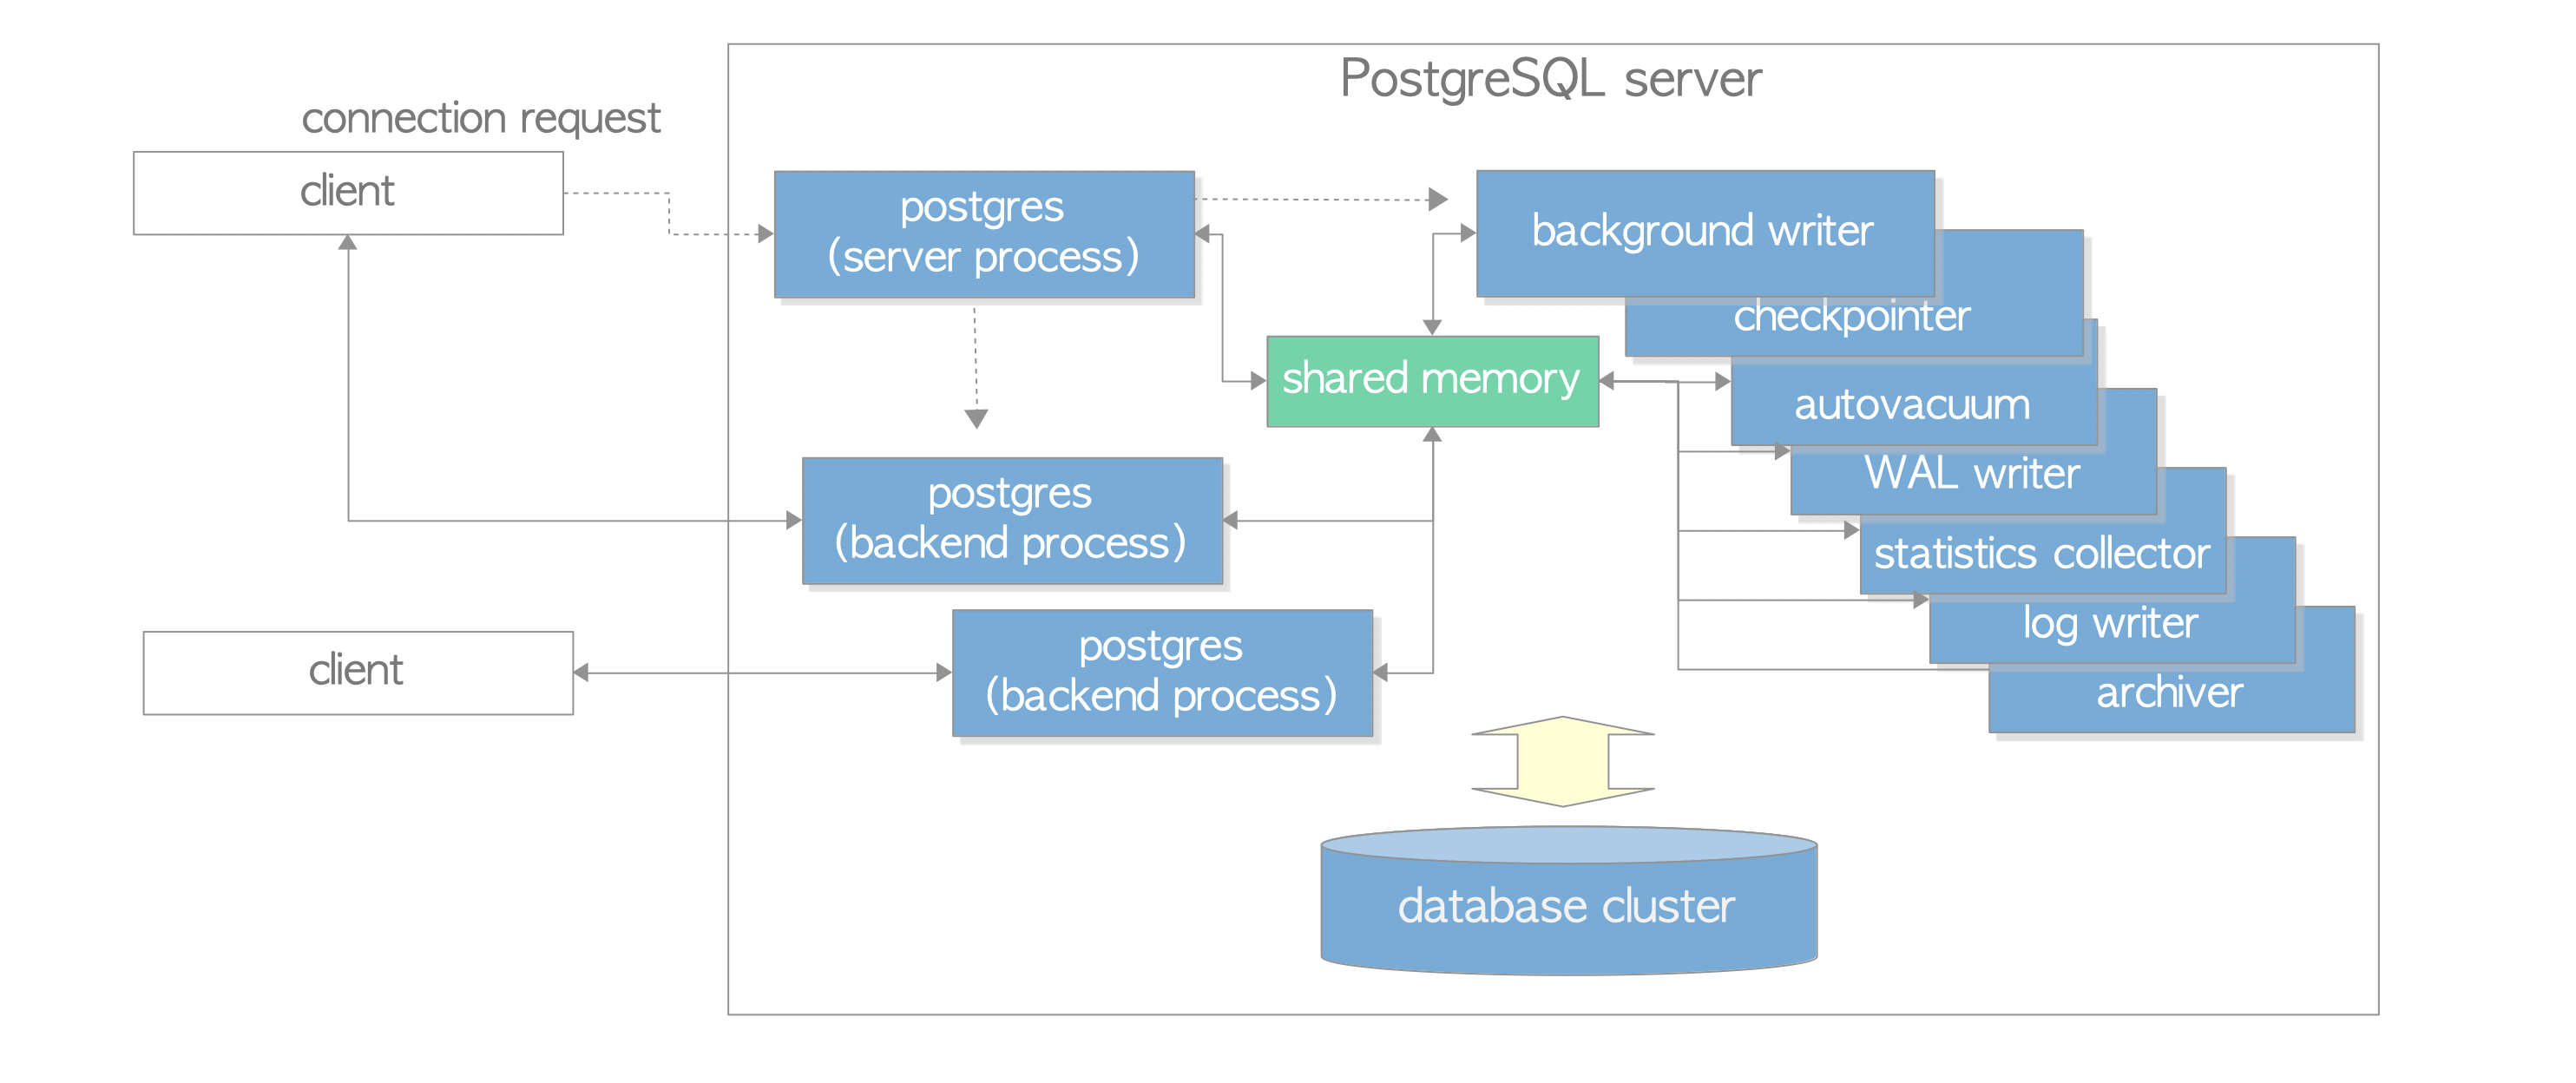

- PostgreSQL 서버의 프로세스(postgres 서버 프로세스, 2개의 백엔드 프로세스, 7개의 백그라운드 프로세스, 2개의 클라이언트 프로세스)
-  데이터베이스 클러스터, 공유 메모리 및 두 개의 클라이언트 프로세스도 설명되어 있음.

**Postgres 서버 프로세스**

- postgres 서버 프로세스는 PostgreSQL 서버에 있는 모든 프로세스의 상위 프로세스.
  - 이전 버전에서는 'postmaster'라고 불렀음.

- 'start' 옵션을 사용하여 pg_ctl 유틸리티를 실행하면 postgres 서버 프로세스가 시작.
-  그런 다음 메모리에 공유 메모리 영역을 할당 > 다양한 백그라운드 프로세스를 시작 > 필요한 경우 복제 관련 프로세스와 백그라운드 작업자 프로세스를 시작 > 클라이언트의 연결 요청을 기다림.
-  클라이언트로부터 연결 요청을 받을 때마다 백엔드 프로세스를 시작. (시작된 백엔드 프로세스는 연결된 클라이언트가 발행한 모든 쿼리를 처리.)

- Postgres 서버 프로세스는 하나의 네트워크 포트를 수신하며 기본 포트는 5432.
-  둘 이상의 PostgreSQL 서버가 동일한 호스트에서 실행될 수 있지만 각 서버는 5432, 5433 등과 같은 서로 다른 포트 번호를 수신하도록 설정.

**백엔드 프로세스**

- 'postgres' 프로세스라고도 하는 백엔드 프로세스는 postgres 서버 프로세스에 의해 시작되며 연결된 하나의 클라이언트에서 발행된 모든 쿼리를 처리.
- 단일 TCP 연결을 사용하여 클라이언트와 통신하고 클라이언트 연결이 끊어지면 종료.

- 백엔드 프로세스는 하나의 데이터베이스에서만 작동하도록 허용되므로 PostgreSQL 서버에 연결할 때 사용할 데이터베이스를 명시적으로 지정해야 함.

- PostgreSQL을 사용하면 여러 클라이언트가 동시에 연결할 수 있음.
  - 구성 매개변수 max_connections는 최대 클라이언트 수를 제어(기본값은 100).

- 웹 애플리케이션과 같은 많은 클라이언트가 PostgreSQL 서버에 자주 연결하고 연결을 끊는 경우 PostgreSQL에는 기본 연결 풀링 기능이 없으므로 연결 설정 및 백엔드 프로세스 생성 비용이 증가할 수 있음.
  - 이는 데이터베이스 서버의 성능에 부정적인 영향을 미칠 수 있음.

- 이러한 경우를 처리하기 위해 일반적으로 pgbouncer 또는 pgpool-II 와 같은 연결 풀링 미들웨어가 사용됨.

**백그라운드 프로세스**

- Postgres 서버 프로세스나 백엔드 프로세스와 달리 각 기능을 간단하게 설명하는 것은 불가능.
-  이는 이러한 기능이 개별 특정 기능과 PostgreSQL 내부에 의존하기 때문.

|process|description|
|--|--|
|background writer|	이 프로세스는 공유 버퍼 풀의 더티 페이지를 정기적으로 점진적으로 영구 저장소(예: HDD, SSD)에 씀. (9.1 이전 버전에서는 체크포인트 프로세스도 담당.)|
|checkpointer	|이 프로세스는 버전 9.2 이상에서 체크포인트 프로세스를 수행.|
|autovacuum launcher|	이 프로세스는 진공 프로세스에 대한 autovacuum-worker 프로세스를 주기적으로 호출. (보다 정확하게는 postgres 서버에 autovacuum 작업자를 생성하도록 요청.)	|
|WAL writer|	이 프로세스는 WAL 버퍼의 WAL 데이터를 주기적으로 영구 저장소에 쓰고 플러시.	|
|statistics collector|	이 프로세스는 pg_stat_activity 및 pg_stat_database 등에 대한 통계 정보를 수집|
|logging collector (logger)|	이 프로세스는 오류 메시지를 로그 파일에 기록.|
|archiver|	이 프로세스는 보관 로깅을 실행.	|

<br>

- PostgreSQL 서버의 실제 프로세스

- 다음 예에는 하나의 postgres 서버 프로세스(pid는 9687), 두 개의 백엔드 프로세스(pid는 9697 및 9717) 및 표 2.1에 나열된 여러 백그라운드 프로세스가 있음.



```
postgres> pstree -p 9687
-+= 00001 root /sbin/launchd
 \-+- 09687 postgres /usr/local/pgsql/bin/postgres -D /usr/local/pgsql/data
   |--= 09688 postgres postgres: logger process
   |--= 09690 postgres postgres: checkpointer process
   |--= 09691 postgres postgres: writer process
   |--= 09692 postgres postgres: wal writer process
   |--= 09693 postgres postgres: autovacuum launcher process
   |--= 09694 postgres postgres: archiver process
   |--= 09695 postgres postgres: stats collector process
   |--= 09697 postgres postgres: postgres sampledb 192.168.1.100(54924) idle
   \--= 09717 postgres postgres: postgres sampledb 192.168.1.100(54964) idle in transaction
```
